In [8]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from collections import defaultdict
from matplotlib.backends.backend_pdf import PdfPages
fig_store = "../../MasterThesis/Thesis/figures/PyMC/"
import pymc as pm
import numpy as np
from matplotlib import pyplot as plt
import math
import time
import random

## Data Structure

In [2]:
def random_limit(distribution):
    val = distribution.random()
    while val > 1 or val < 0:
        val = distribution.random()
    return val

class grader(object):
    def __init__(self, name,bias_mean,bias_tau):
        self.name = name
        self.handins = list()
        self.bias_mean = bias_mean
        self.bias_tau = bias_tau
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
    def grade_handins(self):
        for handin in self.handins:
            B = pm.Normal('B_generator',self.bias_mean,self.bias_tau)
            handin.add_gradeing(self,B.random())

class handin:
    def __init__(self,title,owner,true_value,precision):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.true_val = true_value
        self.precision = precision
    
    def add_grader(self,grader):
        self.graders.append(grader)
    
    def add_gradeing(self,grader,bias):
        obs = pm.Normal('obs_generator',self.true_val+grader.bias_mean,self.precision+grader.bias_tau)
        self.gradeings[grader.name] = random_limit(obs)
        
        
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.name == grader.name):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin
            
    def grade_handins(self,n_handins):
        # Distribute handins
        for i in xrange(0,n_handins):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
                
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins()

## Generate Observed Data

In [3]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()
graders_data = list()

for i in xrange(0,20):
    g = grader('grader_%i' % i,B_mu.random(),B_tau.random())
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, g, t_mu, T_tau.random())
    graders_data.append(g)
    handins_data.append(h)
    
assignment_data_true = assignment(handins_data,graders_data)
assignment_data_true.grade_handins(5)

In [ ]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()

for i in xrange(60,120):
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, graders_data[i-60], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data_2 = assignment(handins_data,graders_data)
assignment_data_2.grade_handins(10)

In [ ]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()

for i in xrange(40,60):
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, graders_data[i-60], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data_3 = assignment(handins_data,graders_data)
assignment_data_3.grade_handins(10)

## Models

In [4]:
def execute_model(model,data,samples,burn):
    mcmc = pm.MCMC(model(data))
    mcmc.sample(samples,burn)
    return mcmc

In [5]:
def handin_model_Oles(data):
    N_H = len(data)
    
    # Bias
    T_mu = dict()
    T_tau = dict()
    T = dict()
    B_mu = dict()
    B = dict()
    B_tau = dict()
    O = list()
    
    e = pm.Gamma('error',10,0.1)
    
    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T[h_id] = pm.Normal('T_%s' % str(h_id), T_mu[h_id], T_tau[h_id])        
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), B_mu[g_id], B_tau[g_id])
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=e, observed=True, value=val))
                               
    collection = [pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(T),
                  pm.Container(B_mu),
                  pm.Container(B_tau),
                  pm.Container(B),
                  pm.Container(O),
                  e]
    
    model = pm.Model(collection)
    return model


In [6]:
def peergrade_model(data):
    
    # Initialize Containers for posterior
    mu_h = dict()
    tau_h = dict()
    mu_g = dict()
    tau_g = dict()
    O = list()

    for h_id, handin in data.handins.iteritems():
        
        mu_h[h_id] = pm.Normal('mu_h_%s' % str(h_id),0.5,25)
        tau_h[h_id] = pm.Gamma('tau_h_%s' % str(h_id),10,0.1)
        
        for g_id, val in handin.gradeings.iteritems():
            
            if g_id not in mu_g:
                mu_g[g_id] = pm.Normal('mu_g_%s' % str(g_id),0,100)
                tau_g[g_id] = pm.Gamma('tau_g_%s' % str(g_id), 50, 0.1)
                
            O.append(pm.Normal('O_%s_%s' % (h_id,g_id), 
                               mu = mu_h[h_id] + mu_g[g_id], 
                               tau=tau_h[h_id] + tau_g[g_id], 
                               observed=True, value=val))
               
    collection = [pm.Container(mu_g), pm.Container(tau_g),
                  pm.Container(mu_h), pm.Container(tau_h),
                  pm.Container(O)]
    
    model = pm.Model(collection)
    return model

In [ ]:
def norm_log_pdf(x,u,t):
    return -0.5*t*(x-u)**2+np.log(t)-np.log(np.sqrt(2.0*math.pi))

def gamma_log_pdf(x,a,b):
    return a*np.log(b)-np.log(math.gamma(a))+(a-1.0)*np.log(x)-b*x

def norm_gamma_log_pdf(u,t,ga,la,a,b):
    return a*np.log(b)+np.log(np.sqrt(la))-np.log(math.gamma(a))- \
           np.log(np.sqrt(2.0*math.pi))+(a-1)*np.log(t)-np.log(b*t) \
           -0.5*t*la*(u-ga)**2

In [ ]:
def MH_model(data,samples,burn_in=0):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    
    log_h = dict()
    log_g = dict()

    def prop_u_t_h(handin,u_h,t_h):
        sum_ = 0.0
        for g, val in handin.gradeings.iteritems():
            sum_ = sum_ + norm_log_pdf(val,u_g[g]+u_h,t_g[g]+t_h)
        return sum_ + norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        sum_ = 0.0
        for h in grader.handins:
            val = h.gradeings[str(g)]
            sum_ = sum_ + norm_log_pdf(val,u_g+u_h[h.title],t_g+t_h[h.title])
        return sum_ + norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    
    # Draw from priors
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_g * t_h[h])))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g]))) 
    # Initialize log-likelihood
    for h, handin in data.handins.iteritems():
        log_h[h] = prop_u_t_h(handin,u_h[h],t_h[h])
    for g, grader in data.graders.iteritems():
        log_g[g] =prop_u_t_g(grader,g,u_g[g],t_g[g])
        
    # Tracers initialising
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
        
    # Sampling
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample u_h and t_h
        for h, handin in data.handins.iteritems():
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            # Calculate logliklihood from target distribution
            p_ = prop_u_t_h(handin,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g, grader in data.graders.iteritems():
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            # Calculate logliklihood from target distribution
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Collect tracings
        if r > burn_in:
            for h in data.handins.iterkeys():
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
            for g in data.graders.iterkeys():
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])

    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g}

    return traces

In [ ]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_peergrade_2 = execute_model(peergrade_model,assignment_data_true,1000,0)

graders:time
20:14.8
40:31.1
100:80.7

In [7]:
mcmc_peergrade = execute_model(peergrade_model,assignment_data_true,11000,1000)

 [-----------------100%-----------------] 11000 of 11000 complete in 201.0 sec

In [ ]:
mcmc_MH_2 = MH_model(assignment_data_true,1000)

graders:time
20:6.215399
40:12.993867
100:30.285429

In [ ]:
mcmc_MH = MH_model(assignment_data_true,10000,1000)

## Plot

In [18]:
def plot_traces_bias(assignment,mcmc):
    bias_abs = list()
    for i, g in enumerate(assignment.graders.keys()):
        if i < 5:
            continue
        plt.subplot(2,1,1) 
        
        b_mu = mcmc.trace('mu_g_%s' % str(g))[:]
        plt.plot(b_mu,color="#467821",label=r'posterior $p_{\mu_b}$')
        
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.4)
        
        plt.subplot(2,1,2) 
        
        b_tau = mcmc.trace('tau_g_%s' % str(g))[:]
        plt.plot(b_tau,color="#467821",label=r'posterior $p_{\tau_b}$')

        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.4)
        plt.suptitle("Traces of %s" % g, fontsize=12)
        plt.xlabel("Steps")
        plt.show()
        return None

In [15]:
def plot_traces_handin(assignment,mcmc):
    for i, g in enumerate(assignment.handins.keys()):
        plt.subplot(2,1,1) 
        
        b_mu = mcmc.trace('mu_h_%s' % str(g))[:]
        plt.plot(b_mu,color="#348ABD",label=r'posterior $p_{\mu_h}$')
        #plt.title("Grading score for %s" % g)
        leg = plt.legend(loc=4)
        leg.get_frame().set_alpha(0.4)
#        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.subplot(2,1,2) 

        b_tau = mcmc.trace('tau_h_%s' % str(g))[:]
        plt.plot(b_tau,color="#348ABD",label=r'posterior $p_{\tau_h}$')
#        plt.title("Grading score for handin %s" % g)
#        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.4)
        plt.suptitle("Traces of %s" % g, fontsize=12)
        plt.xlabel("Steps")
        plt.show()
        break

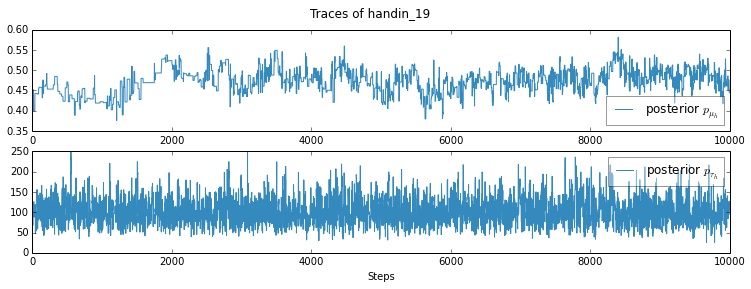

In [16]:
with PdfPages(fig_store + "peergrade_traces_handin.pdf") as pdf:
    fig = plt.figure(figsize(12.5, 4))
    plot_traces_handin(assignment_data_true,mcmc_peergrade)
    pdf.savefig(fig,bbox_inches='tight')

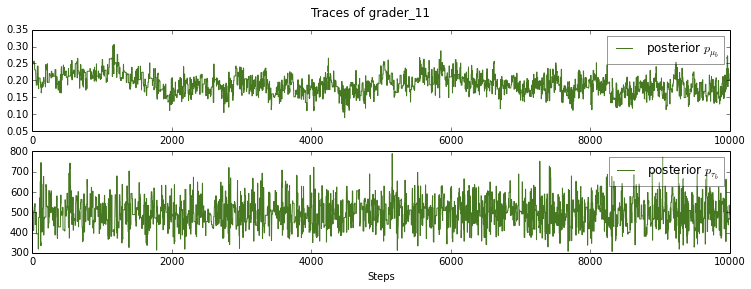

In [19]:
with PdfPages(fig_store + "peergrade_traces_bias.pdf") as pdf:
    fig = plt.figure(figsize(12.5, 4))
    plot_traces_bias(assignment_data_true,mcmc_peergrade)
    pdf.savefig(fig,bbox_inches='tight')

In [20]:
from scipy.stats import norm

In [ ]:
def plot_dist(assignment,mcmc):
    figsize(12.5, 6)

    for i, (g, data) in enumerate(assignment.handins.iteritems()):

        plt.subplot(2,1,1) 
        x = np.linspace(0,1,1000)    
        h_mean = np.mean(mcmc.trace('T_mu_%s' % str(g))[:])
        h_std = np.sqrt(1.0 / np.mean(mcmc.trace('T_tau_%s' % str(g))[:]))
        print h_mean, h_std
        
        y = norm.pdf(x, loc=h_mean, scale=h_std)
        plt.plot(x,y,color="#348ABD",label=r'Posterior distriubtion of $p_{T_h}$')
        plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        
        y = norm.pdf(x, loc=data.true_val, scale=np.sqrt(1.0 / data.precision))
        plt.plot(x,y,color="gray",label=r'True distribution of $p_{T_h}$')
        
        plt.vlines(h_mean, 0, 5, linestyle="--", linewidth=2, label=r'Expected value of $p_{T_h}$')
        plt.title(r'Prior distribution of $T_h$ where $h$ is %s' % g, fontsize=12)
        plt.ylim(0,5)
        leg = plt.legend(loc=2)
        leg.get_frame().set_alpha(0.4)
        break
        
    for i, (g,data) in enumerate(assignment.graders.iteritems()):
        if i < 5:
            continue
        plt.subplot(2,1,2) 
        x = np.linspace(-0.2,0.2,1000)            
        
        b_mean = np.mean(mcmc.trace('B_mu_%s' % str(g))[:])
        b_std = np.sqrt(1.0 / np.mean(mcmc.trace('B_tau_%s' % str(g))[:]))
        y = norm.pdf(x, loc=b_mean, scale=b_std)
        plt.plot(x,y,color="#467821",label=r'Posterior distribution of $p_{B_g}$')
        plt.fill_between(x, 0, y, color="#467821", alpha=0.4)
        
        y = norm.pdf(x, loc=data.bias_mean, scale=np.sqrt(1.0 / data.bias_tau))
        plt.plot(x,y,color="gray",label=r'True distribution of $p_{B_g}$')

        plt.vlines(b_mean, 0, 10, linestyle="--", linewidth=2, label=r'Expected value of $p_{B_g}$')
        plt.title(r'Prior distribution of $B_g$ where $g$ is %s' % g, fontsize=12)
        leg = plt.legend(loc=2)
        leg.get_frame().set_alpha(0.4)
        plt.ylim(0,10)
        plt.xlim(-0.2,0.2)
        break


#        leg.get_frame().set_alpha(0.4)
#    plt.suptitle("Posterior distributions of a handin score and bias")
    plt.show()
#    plt.tight_layout()

# title

JDAWFWAD

In [ ]:
plot_dist(assignment_data_true,mcmc_peergrade)

In [ ]:
def plot_traces_bias_(assignment,mcmc):
    figsize(12.5, 4)
    bias_abs = list()
    for i, g in enumerate(assignment.graders.keys()):
        if i < 5:
            continue
        plt.subplot(2,1,1) 
        
        b_mu = mcmc['u_g'][str(g)][:]
        plt.plot(b_mu,color="#467821",label=r'posterior $p_{\mu_b}$')
        
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.4)
        
        plt.subplot(2,1,2) 
        b_tau = mcmc['t_g'][str(g)][:]
        plt.plot(b_tau,color="#467821",label=r'posterior $p_{\tau_b}$')

        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.4)
        plt.suptitle("Traces of %s" % g, fontsize=12)
        plt.xlabel("Steps")
        plt.show()
        plt.tight_layout()
        return None

In [ ]:
def plot_traces_handin_(assignment,mcmc):
    figsize(12.5, 4)
    for i, g in enumerate(assignment.handins.keys()):
        plt.subplot(2,1,1) 
        
        b_mu = mcmc['u_h'][str(g)][:]
        plt.plot(b_mu,color="#348ABD",label=r'posterior $p_{\mu_h}$')
        #plt.title("Grading score for %s" % g)
        leg = plt.legend(loc=4)
        leg.get_frame().set_alpha(0.4)
#        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.subplot(2,1,2) 

        b_tau = mcmc['t_h'][str(g)][:]
        plt.plot(b_tau,color="#348ABD",label=r'posterior $p_{\tau_h}$')
#        plt.title("Grading score for handin %s" % g)
#        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.4)
        plt.suptitle("Traces of %s" % g, fontsize=12)
        plt.xlabel("Steps")
        plt.show()
        plt.tight_layout()
        break

In [ ]:
with PdfPages(fig_store + "CompareSpeedScaling.pdf") as pdf:
    fig = plt.figure(figsize(7,4))
    plot_traces_handin(assignment_data_true,mcmc_peergrade)
    pdf.savefig(fig,bbox_inches='tight')

plot_traces_handin_(assignment_data_true,mcmc_MH)

In [ ]:
#with PdfPages(fig_store + "CompareSpeedScaling.pdf") as pdf:
    fig = plt.figure(figsize(7,4))
    plot_traces_handin(assignment_data_true,mcmc_peergrade)
    pdf.savefig(fig,bbox_inches='tight')

#plot_traces_bias_(assignment_data_true,mcmc_MH)

In [ ]:
def plot_dist_(assignment,mcmc):
    figsize(12.5, 6)

    for i, (g, data) in enumerate(assignment.handins.iteritems()):

        plt.subplot(2,1,1) 
        x = np.linspace(0,1,1000)    
        h_mean = np.mean(mcmc['u_h'][g][:])
        h_std = np.sqrt(1.0 / np.mean(mcmc['t_h'][g][:]))
        print h_mean, h_std
        
        y = norm.pdf(x, loc=h_mean, scale=h_std)
        plt.plot(x,y,color="#348ABD",label=r'Posterior distriubtion of $p_{T_h}$')
        plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        
        y = norm.pdf(x, loc=data.true_val, scale=np.sqrt(1.0 / data.precision))
        plt.plot(x,y,color="gray",label=r'True distribution of $p_{T_h}$')
        
        plt.vlines(h_mean, 0, 5, linestyle="--", linewidth=2, label=r'Expected value of $p_{T_h}$')
        plt.title(r'Prior distribution of $T_h$ where $h$ is %s' % g, fontsize=12)
        plt.ylim(0,5)
        leg = plt.legend(loc=2)
        leg.get_frame().set_alpha(0.4)
        break
        
    for i, (g,data) in enumerate(assignment.graders.iteritems()):
        if i < 4:
            continue
        plt.subplot(2,1,2) 
        x = np.linspace(-0.2,0.2,1000)            
        
        b_mean = np.mean(mcmc['u_g'][g][:])
        b_std = np.sqrt(1.0 / np.mean(mcmc['t_g'][g][:]))
        y = norm.pdf(x, loc=b_mean, scale=b_std)
        plt.plot(x,y,color="#467821",label=r'Posterior distribution of $p_{B_g}$')
        plt.fill_between(x, 0, y, color="#467821", alpha=0.4)
        
        y = norm.pdf(x, loc=data.bias_mean, scale=np.sqrt(1.0 / data.bias_tau))
        plt.plot(x,y,color="gray",label=r'True distribution of $p_{B_g}$')

        plt.vlines(b_mean, 0, 10, linestyle="--", linewidth=2, label=r'Expected value of $p_{B_g}$')
        plt.title(r'Prior distribution of $B_g$ where $g$ is %s' % g, fontsize=12)
        leg = plt.legend(loc=2)
        leg.get_frame().set_alpha(0.4)
        plt.ylim(0,10)
        plt.xlim(-0.2,0.2)
        break


#        leg.get_frame().set_alpha(0.4)
#    plt.suptitle("Posterior distributions of a handin score and bias")
    plt.show()
#    plt.tight_layout()

In [ ]:
plot_dist_(assignment_data_true,mcmc_MH)

In [21]:
def find_bias(assignment,mcmc,f):
    bias = list()
    for g in assignment.graders.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc.trace('tau_g_%s' % str(g))[:])
        elif f == 'mean':
            value = np.mean(mcmc.trace('mu_g_%s' % str(g))[:])
        bias.append((value,g))
    return bias

In [22]:
def find_T(assignment,mcmc,f):
    T = list()
    for h in assignment.handins.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc.trace('tau_h_%s' % str(h))[:])
        elif f == 'mean':
            value = np.mean(mcmc.trace('mu_h_%s' % str(h))[:])
        T.append((value,h))
    return T

In [23]:
def MAE(true,estimated):
    return np.mean(map(lambda x : (x[0] - x[1])**2,zip(true,estimated)))

In [27]:
def compare_to_generated(assignment_data,mcmc_handins,find,func='mean',ax=None):
    bias_abs_1 = find(assignment_data, mcmc_handins, func)
    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = bias_abs_1[:]
    
    for (value, _id) in collected:
        compared[_id] = value
        
    sorted_list = list()
    if "bias" in find.func_name:
        for _id, g in assignment_data.graders.iteritems():
            if func == "mean":
                sorted_list.append((_id,g.bias_mean))
            else:
                sorted_list.append((_id,g.bias_tau))
    else:
        for _id, h in assignment_data.handins.iteritems():
            if func == "mean":
                sorted_list.append((_id,h.true_val))
            else:
                sorted_list.append((_id,h.precision))
            
    sorted_list.sort(key=lambda x: x[1])
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    tau_score_values = list()
    MS_val = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
        if "bias" not in find.func_name:
            if func == "mean":
                mean_score = np.mean(assignment_data.handins[_id].gradeings.values())
                mean_score_values.append(mean_score)
        
        MS_val.append(compared[_id])
        score_values.append(compared[_id])
        true_values.append(value)
        labels.append(_id)
    
#    MSE_T = 0.0
#    MAE_M = MAE(true_values,MS_val)
#    print MAE_M
#    if "bias" not in find.func_name and func == "mean":
#        MAE_T = MAE(true_values,mean_score_values)
#        print MAE_T
#    box_text = ""
#    if func == "mean" and ax:
#        if "bias" not in find.func_name:
#            box_text = 'MSE model: %f\nMSE graded: %f' % (MSE_M,MSE_T)
#        else:
#            box_text = 'MSE model: %f' % MSE_M
#        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#        ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14,
#            verticalalignment='top', bbox=props)
    
    y_ = map(lambda x: x,y)
    if "bias" in find.func_name:
        plt.plot(score_values,y_,'o',color="#467821",label="Expected value of\nposterior",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',color="#A60628",label="True value",alpha=0.6,linewidth=0)
    else:
        if func == "mean":
            plt.plot(mean_score_values,y,'o',color="#A60628",label="Mean value of\nobserved scores",alpha=0.6)
        plt.plot(score_values,y,'o',color='#348ABD',label="Expected value of\nposterior",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',label="True value",alpha=0.6,linewidth=0)
    plt.yticks(xrange(0,len(sorted_list)),labels)
    leg = plt.legend(loc=4,numpoints=1)
    leg.get_frame().set_alpha(0.4)
    if "bias" in find.func_name:
        if func == "mean":
            plt.title(r'True $\mu_g$ compared to infered $\mu_g$')
        else:
            plt.title(r'True $\tau_g$ compared to infered $\tau_g$')
        plt.ylabel("Graders")
    else:
        if func == "mean":
            plt.title(r'True $\mu_h$ compared to infered $\mu_h$')
        else:
            plt.title(r'True $\tau_h$ compared to infered $\tau_h$')
        plt.ylabel("Handins")

### Peergrad_model

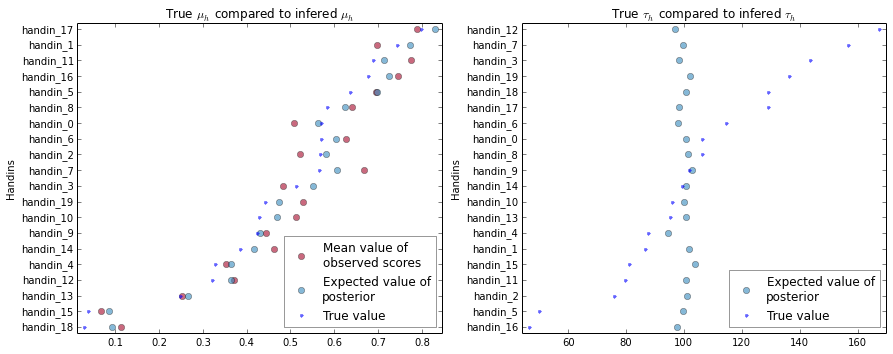

In [30]:
with PdfPages(fig_store + "peergrade_compare_handin.pdf") as pdf:
    fig = plt.figure(figsize(12.5, 5))
    
    ax = plt.subplot(1,2,1)
    compare_to_generated(assignment_data_true,mcmc_peergrade,find_T,'mean',ax)
    plt.margins(0.02)
    plt.subplot(1,2,2)
    compare_to_generated(assignment_data_true,mcmc_peergrade,find_T,'var')
    plt.margins(0.02)
    plt.tight_layout()
    
    
    pdf.savefig(fig,bbox_inches='tight')

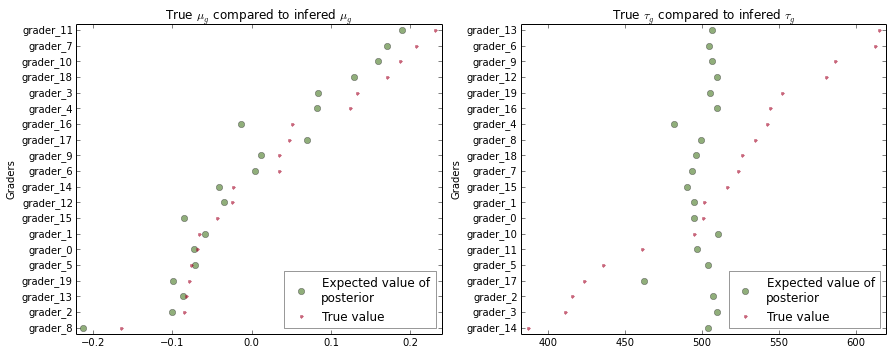

In [31]:
with PdfPages(fig_store + "peergrade_compare_bias.pdf") as pdf:
    fig = plt.figure(figsize(12.5, 5))
    
    ax = plt.subplot(1,2,1)
    compare_to_generated(assignment_data_true,mcmc_peergrade,find_bias,'mean',ax)
    plt.margins(0.02)
    plt.subplot(1,2,2)
    compare_to_generated(assignment_data_true,mcmc_peergrade,find_bias,'var')
    plt.margins(0.02)
    plt.tight_layout()
    
    pdf.savefig(fig,bbox_inches='tight')

###  MH model

In [ ]:
def find_bias_(assignment,mcmc,f):
    bias = list()
    for g in assignment.graders.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc['t_g'][g][:])
        elif f == 'mean':
            value = np.mean(mcmc['u_g'][g][:])
        bias.append((value,g))
    return bias

In [ ]:
def find_T_(assignment,mcmc,f):
    T = list()
    for h in assignment.handins.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc['t_h'][h][:])
        elif f == 'mean':
            value = np.mean(mcmc['u_h'][h][:])
        T.append((value,h))
    return T

In [ ]:
figsize(12,5)
ax = plt.subplot(1,2,1)
compare_to_generated(assignment_data_true,mcmc_MH,find_T_,'mean',ax)
plt.margins(0.02)
plt.subplot(1,2,2)
compare_to_generated(assignment_data_true,mcmc_MH,find_T_,'var')
plt.margins(0.02)
plt.tight_layout()

In [ ]:
figsize(12,5)
ax = plt.subplot(1,2,1)
compare_to_generated(assignment_data_true,mcmc_MH,find_bias_,'mean',ax)
plt.margins(0.02)
plt.subplot(1,2,2)
compare_to_generated(assignment_data_true,mcmc_MH,find_bias_,'var')
plt.margins(0.02)
plt.tight_layout()

## Oles

In [ ]:
compare_to_generated(assignment_data_true,[mcmc_ole[0]]*3,find_bias,'mean')

### Model Comparison over 5 different data set

The model have been used on 5 different generated data set and then compared against eachother to see if one model is better than the others

In [ ]:
mesured_error = [[(4,0.001756),(1,0.001816),(2,0.001840),(3,0.002005),(6,0.002081),(5,0.002301)],
                 [(2,0.002043),(6,0.002046),(4,0.002279),(1,0.002351),(5,0.002987),(3,0.003079)],
                 [(6,0.001045),(3,0.001053),(4,0.001083),(1,0.001239),(2,0.001284),(5,0.003088)],
                 [(2,0.000934),(3,0.000990),(1,0.001000),(4,0.001183),(6,0.001282),(5,0.002000)],
                 [(4,0.001913),(1,0.002172),(2,0.002586),(3,0.002744),(6,0.003017),(5,0.003726)],
                 [(2,0.001213),(6,0.001242),(4,0.001312),(3,0.001362),(1,0.001644),(5,0.002533)],
                 [(1,0.000791),(6,0.000813),(3,0.000890),(4,0.000918),(2,0.000956),(5,0.001501)]]

In [ ]:

ax = plt.subplot(111)
colors = ['r','b','g','m','c','y']
lines = defaultdict(list)
for set_,data in enumerate(mesured_error):
    for (model,error) in data:
        lines[model].append((set_,error))
    
for model, l in lines.iteritems():
    xs = list()
    ys = list()
    for i in xrange(len(lines)+1):
        (x1,y1) = l[i]
        xs.append(x1+1)
        ys.append(y1)
    
    line = plt.plot(xs,ys,colors[model-1],label="model %i" % model)


box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*2, box.height*1.5])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("dataset")
plt.ylabel("Mean Square Error")
plt.show()

In [ ]:
pos_m = defaultdict(list)
for set_,data in enumerate(mesured_error):
    for (pos, (model,error)) in enumerate(data):
        pos_m[model].append(pos)
        
for m, pos in pos_m.iteritems():
#    print m, pos
    print "model_" + str(m) + ": mean: " + str(np.mean(pos)) + ", median: " + str(np.median(pos))